# Cluster

Description

In [5]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path

path = str(Path.cwd().parent)
sys.path.append(path)

In [6]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import umap.plot

from datatype.dataframe import Dataframe
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datatype.spectrogram import flatten
from umap import validation

In [3]:
file = Dataframe()
dataframe = file.load()
    
mask = (~dataframe.exclude & dataframe.duration > 0) 
dataframe = dataframe[mask]

In [4]:
spectrogram = dataframe['spectrogram'].values.tolist()
flattened = flatten(spectrogram)

In [5]:
del dataframe
del spectrogram

gc.collect()

0

In [6]:
um = umap.UMAP(
    low_memory=True,
    metric='l2',
    min_dist=0.0,
    n_neighbors=5,
    n_components=2,
    n_jobs=-1
)

In [7]:
embedding = um.fit_transform(flattened)

In [12]:
path = PICKLE.joinpath('2d_embedding.xz')

with lzma.open(path, 'wb') as handle:
    pickle.dump(embedding, handle)

In [8]:
path = PICKLE.joinpath('2d_embedding.xz')

with lzma.open(path, 'rb') as handle:
    embedding = pickle.load(handle)

In [ ]:
_, dimension = embedding.shape

for i in range(dimension):
    if i == 0:
        dataframe['x'] = embedding[:, i]
    else:
        dataframe['y'] = embedding[:, i]

In [ ]:
trustworthiness = validation.trustworthiness_vector(
    source=um._raw_data,
    embedding=um.embedding_,
    max_k=30
)

plt.plot(trustworthiness)
plt.ylabel('Value of k')
plt.xlabel('Trustworthiness score')
plt.title('Trustworthiness')

In [9]:
projection = list(embedding)
projection = np.vstack(projection)

In [ ]:
cluster = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(embedding)

In [ ]:
scoring = make_scorer(
    hdbscan.validity.validity_index,
    greater_is_better=True
)

In [ ]:
# n_iter = 20

# param_distributions = {
#     'cluster_selection_method' : ['eom', 'leaf'],
#     'metric' : ['euclidean', 'manhattan'],
#     'min_cluster_size':[i for i in range(100, 1000, 100)],  
#     'min_samples': [i for in range(10, 100, 10)]
# }

# search = RandomizedSearchCV(
#     cluster,
#     param_distributions=param_distributions,
#     n_iter=n_iter,
#     n_jobs=-1,
#     scoring=scoring
# )

In [ ]:
param_grid = {
    'cluster_selection_method' : ['eom', 'leaf'],
    'min_cluster_size':[i for i in range(100, 1000, 100)],  
    'min_samples': [i for i in range(10, 100, 10)]
}

search = GridSearchCV(
    cluster,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=scoring
)

In [ ]:
search.fit(embedding)

print(f"Best Parameters {search.best_params_}")
print(f"DBCV Score :{search.best_estimator_.relative_validity_}")

In [ ]:
cluster = hdbscan.HDBSCAN(
    cluster_selection_method='eom',
    min_cluster_size=100,
    min_samples=10,
    gen_min_span_tree=True
).fit(embedding)

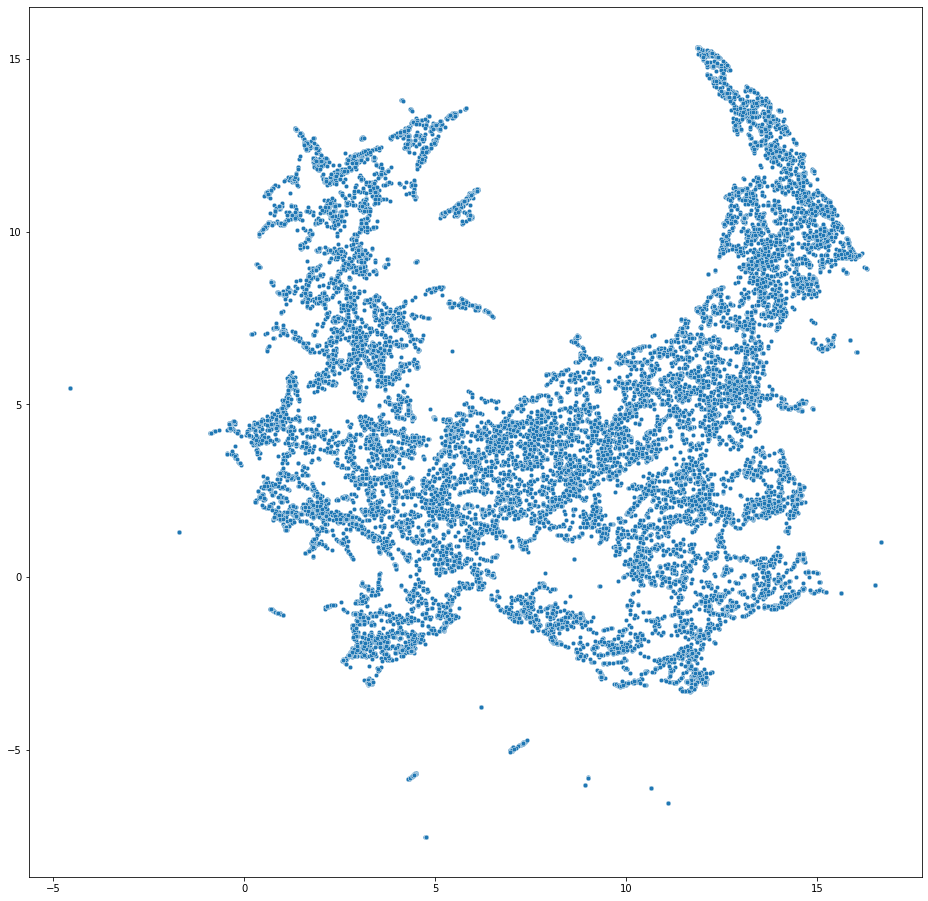

In [10]:
figsize = (16, 16)
fig, ax = plt.subplots(figsize=figsize)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    # hue=list(cluster.labels_),
    palette='tab20',
    legend='full',
    s=20,
)

plt.show()
plt.close()

In [ ]:
figsize = (16, 16)
fig, ax = plt.subplots(figsize=figsize)

sns.histplot(
    cluster.outlier_scores_[np.isfinite(cluster.outlier_scores_)],
    ax=ax,
    color='blue',
    kde=True
)

# ax.set_xlim(0, 0.6)
# ax.set_ylim(0, 2000)

plt.show()
plt.close()

In [ ]:
threshold = pd.Series(cluster.outlier_scores_).quantile(0.9)
outliers = np.where(cluster.outlier_scores_ > threshold)[0]

figsize = (16, 16)
fig, ax = plt.subplots(figsize=figsize)

plt.scatter(
    *embedding.T,
    alpha=0.25,
    c='gray'
)

plt.scatter(
    *embedding[outliers].T,
    alpha=0.5,
    c='red'
)

plt.show()
plt.close()